In [1]:
import time
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from openvino.runtime import Core, serialize
from openvino.tools import mo

In [2]:
# The paths of the source and converted models.
model_dir = Path("model")
model_dir.mkdir(exist_ok=True)

model_path = Path("model/efficientnet_b2")

ir_path = Path("model/efficientnet_b2.xml")

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2
import json
import numpy as np
model_path = Path("model/efficientnet_b2")

model = EfficientNetB2()
model.save_weights(f"{model_path}/efficientnet_b2_weights.h5")

class CustomJSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, tf.Tensor):
            return obj.numpy().tolist()  # Convert to a regular Python list
        return super().default(obj)
model_config_json = json.dumps(model.get_config(), cls=CustomJSONEncoder, indent=4)


with open(f"{model_path}/efficientnet_b2_architecture.json", "w") as json_file:
    json_file.write(model_config_json)

In [13]:
# Run model conversion API if the IR model file does not exist
if not ir_path.exists():
    print("Exporting TensorFlow model to IR... This may take a few minutes.")
    ov_model = mo.convert_model(saved_model_dir=model_path, input_shape=[[1, 224, 224, 3]], compress_to_fp16=True)
    serialize(ov_model, ir_path)
else:
    print(f"IR model {ir_path} already exists.")

IR model model\efficientnet_b2.xml already exists.


In [14]:
core = Core()
model = core.read_model(ir_path)

In [15]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [16]:
compiled_model = core.compile_model(model=model, device_name=device.value)

In [17]:
input_key = compiled_model.input(0)
output_key = compiled_model.output(0)
network_input_shape = input_key.shape 

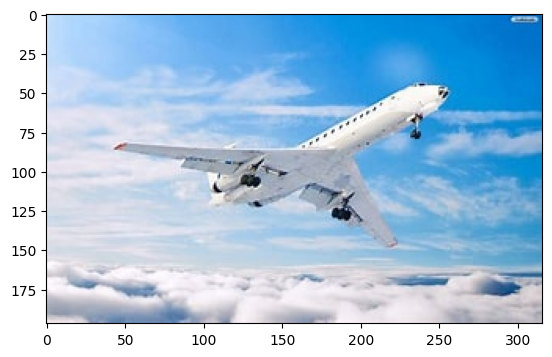

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load and preprocess the image
image = cv2.imread(filename="./aeroplane.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(image_rgb, (224, 224))
input_image = preprocess_input(resized_image)  # Preprocess for EfficientNetB2

# Display the original image
plt.imshow(image_rgb)
plt.show()


In [19]:
result = compiled_model(input_image)[output_key]

result_index = np.argmax(result)

In [20]:
# Convert the inference result to a class name.
imagenet_classes = open("./imagenet_2012.txt").read().splitlines()

imagenet_classes[result_index]

'n02690373 airliner'

In [21]:
num_images = 1000

start = time.perf_counter()

for _ in range(num_images):
    compiled_model([input_image])

end = time.perf_counter()
time_ir = end - start

print(
    f"IR model in OpenVINO Runtime/CPU: {time_ir/num_images:.4f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}"
)

IR model in OpenVINO Runtime/CPU: 0.0096 seconds per image, FPS: 103.75
